1. Setup environment

In [1]:
!pip install 'sagemaker>=2,<3' # upgrade the SageMaker SDK, if environment is not up-to-date, else skip

In [1]:
import sagemaker
from sagemaker import get_execution_role
 
role = get_execution_role() # getting role that gives Sagemaker access to S3 data
print(role)
sess = sagemaker.Session()

arn:aws:iam::241018688765:role/service-role/AmazonSageMaker-ExecutionRole-20200403T163653


In [3]:
training_image = sagemaker.image_uris.retrieve('semantic-segmentation', sess.boto_region_name) # Retreive the docker image for Semantic Segmentaion algorithm
print(training_image)

813361260812.dkr.ecr.eu-central-1.amazonaws.com/semantic-segmentation:1


2. Data Preparation

In [ ]:
# has been prepared using ground truth

3. Data Setup

In [61]:
bucket_name = "sagemaker-awsdemo-marketing"
s3_output_path = 's3://{}/sample_output'.format(bucket_name) # Define folder path on S3 where model artifacts will be stored
print(s3_output_path)

s3://sagemaker-awsdemo-marketing/sample_output


In [62]:
augmented_manifest_filename_train = 'output_train.manifest' # Train manifest file name generated via ground truth labeling job
augmented_manifest_filename_validation = 'output_val.manifest' # Validation manifest file name generated via ground truth labeling job

s3_prefix_train = 'landcover.ai-dataset/labeled_images_sample/manifest_train' # S3 prefix where your train manifest file is kept
s3_prefix_val = 'landcover.ai-dataset/labeled_images_sample/manifest_val' # S3 prefix where your validation manifest file is kept

# Defines paths where manifest files are stored, these paths will be used to create training channels
s3_train_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix_train, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix_val, augmented_manifest_filename_validation)

print("Augmented manifest for training data: {}".format(s3_train_data_path))
print("Augmented manifest for validation data: {}".format(s3_validation_data_path))

Augmented manifest for training data: s3://sagemaker-awsdemo-marketing/landcover.ai-dataset/labeled_images_sample/manifest_train/output_train.manifest
Augmented manifest for validation data: s3://sagemaker-awsdemo-marketing/landcover.ai-dataset/labeled_images_sample/manifest_val/output_val.manifest


4. Training

In [63]:
# Create a model object, and specify hyperparameters such as training image, role, instance type, etc
model = sagemaker.estimator.Estimator(training_image,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.p3.2xlarge', # a GPU-accelerated ml.p3.2xlarge instance to keep our job nice and fast
                                      volume_size = 50,
                                      max_run = 360000,
                                      input_mode = 'Pipe', # Pipe mode is recommended over File mode, as it is faster. 
                                      # In pipe mode dataset is streamed directly to your training instances, however in file mode data will be downloaded first
                                      output_path=s3_output_path,
                                      sagemaker_session=sess)

In [73]:
# Setup hyperparameters, use link 'https://docs.aws.amazon.com/sagemaker/latest/dg/segmentation-hyperparameters.html' for detailed information
model.set_hyperparameters(
    backbone='resnet-50',  # Basically an encoder which is typically a regular CNN (convolutional neural network).
    algorithm='fcn',  # The decoder picks up the outputs of one or many layers from the encoder and reconstructs the segmentation mask from it.                         
    use_pretrained_model='True',  # Semantic Segmentation comes with two choices of pre-trained (restnet-50 and restnet-101) or to be trained-from-scratch backbone networks, Using the pre-trained model for encoder.
    crop_size=240,  # Size of image random crop.                             
    num_classes=4,  # Required parameter, provide number of segmentation classes
    epochs=30,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer='rmsprop',  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly',  # learning rate decay over time, Other options include 'cosine' and 'step'.                           
    mini_batch_size=10,  # The batch size for training. Using a large mini_batch_size usually results in faster training, 
    #but it might cause you to run out of memory. Memory usage is affected by the values of the mini_batch_size and image_shape parameters, and the backbone architecture.
    validation_mini_batch_size=4,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=4,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=15,  # No matter what, run these many number of epochs.                             
    num_training_samples=30,  # Required parameter, number of training images
)

In [74]:
# Create train and validation data channels using path specified above in data setup section
# Note: Algo only supports input_mode as pipe when we are training the model using augmented manifest files
train_data = sagemaker.inputs.TrainingInput(s3_train_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'aws-demo-ref'],
                                        input_mode='Pipe',
                                        record_wrapping='RecordIO')

validation_data = sagemaker.inputs.TrainingInput(s3_validation_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'aws-demo-ref'],
                                        input_mode='Pipe',
                                        record_wrapping='RecordIO') 

manifest_data_channels = {'train': train_data, 'validation': validation_data}

In [76]:
model.fit(inputs=manifest_data_channels, logs=True)

2021-03-09 12:38:43 Starting - Starting the training job...
2021-03-09 12:39:07 Starting - Launching requested ML instancesProfilerReport-1615293523: InProgress
......
2021-03-09 12:40:08 Starting - Preparing the instances for training......
2021-03-09 12:41:08 Downloading - Downloading input data
2021-03-09 12:41:08 Training - Downloading the training image.........
2021-03-09 12:42:36 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[03/09/2021 12:42:40 INFO 139755531789504] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'us

5. Deployment

In [4]:
# deploy model to an endpoint
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

# use already deployed model
#deployed_model = sagemaker.predictor.Predictor("demo-endpoint")

6. Inference

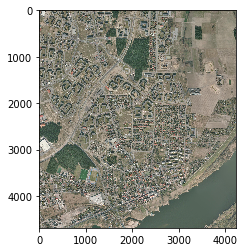

In [5]:
# Define path of the image which needs to be inferred
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
filename_raw  = 'Images/landcover_test.jpg'
im = PIL.Image.open(filename_raw)
plt.imshow(im)
plt.show()

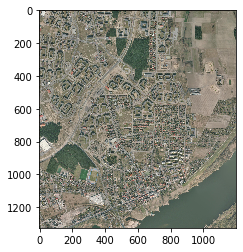

In [10]:
# We have to rescale the image to lower resolution, we can upgrade instance_type while deploying model to endpoint to infer high resolution images. 

import PIL
%matplotlib inline
filename = 'Images/lancover_test_resized.jpg'
width = 1200

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [7]:
# Define serializer and deserializer so that image provided for inference can be in a format that can be read by the deployed model
from PIL import Image
import numpy as np

class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""
    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


deployed_model.deserializer = ImageDeserializer(accept="image/png")
deployed_model.serializer = sagemaker.serializers.IdentitySerializer('image/jpeg')

In [11]:
# opening image and reading it
with open(filename, 'rb') as imfile:
    imbytes = imfile.read()

In [12]:
# predicting on deployed model and storing masked image in variable
results = deployed_model.predict(imbytes)

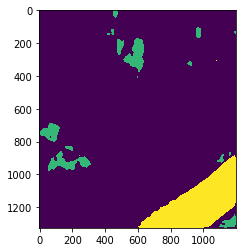

In [13]:
# showing masked image
plt.imshow(results)
plt.show()